In [17]:
#https://docs.scipy.org/doc/scipy/reference/odr.html

#Benotigte Module(inkl. in Anaconda)

import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
from scipy.optimize import *
import random
import sys
import scipy.constants as cons


#um es in einer anderen Datei zu verwende:%run ./odr_v3.ipynb

#MUSS NICHT ANGEPASST WERDEN
#Funktion welche den Fit durchführt 
def fit(x,y,x_err,y_err,beta0=[1., 0.],fix=[1,1]):
    #definerit die zu fittene Funktion,in B sind die Parameter und x ist die unabhängige
    def lin_func(B, x):
        [m,b]=B
        return m*x+b
    lin_model = Model(lin_func)

    #Überprüft welche Fehler angegeben wurden
    if (np.isnan(x_err).any() and np.isnan(y_err).any()):
        data = RealData(x, y)
    elif np.isnan(x_err).any():
        data = RealData(x, y, sy=y_err)
    elif np.isnan(y_err).any():
        data = RealData(x, y, sx=x_err)
    else:
        data = RealData(x, y, sx=x_err, sy=y_err)
    data.set_meta(lab="Ph 7; Lab 26", title="Ag110 + Ag108 Decay")
    #Führt den Fit aus, beta0 sind die Startwerte
    
    odr = ODR(data, lin_model,beta0,ifixb=fix)
    odr.set_job(fit_type=0)
    out = odr.run()
    #out.beta beinhaltet die Parameter
    #out.sd_beta beinhaltet die Fehler der Parameter
    return out

#Muss nicth angepasst werden es sei denn die Ploteigenschaften sollen geädert werden
def zeichnen (x, y,x_err=np.nan,y_err=np.nan,
              
              #x/y werte mit möglichen fehlern
              
              label="f(x)",xlabel="x",  ylabel="y",
              #label für die figur
              
              fx_title="f(x)",x_title="x", m_unit="",b_unit="",
              #label für den Titel:
              #fx_title=(m\pm m_err) m_unit *x_title + (b\pm b_err) b_unit
              
              speichername="",save=True,
              #werte zum speichern mit 300dpi als png
              
              beta0=[1., 0.],scientific=[0,0],fix=[1,1],
              #startwerte für den linearen fit und die option m/b in scientific form zu schreiben
              
              odr=True,scale=False,show=True):
              #entweder odr oder curvefit benutzen
              #scale=False: odr scaliert die fehler nicht(so wie bei absolute_sigma=true)
              #use plt.show() wenn False kann man den plot dannach bearbeiten
                
    #Überprüft ob x&y die selbe Länge haben
    if not(len(x)==len(y)):
        sys.exit("Die Länge von x und y stimmen nicht überein")
        
    if (type(x_err)==int or type(x_err)==float or type(x_err)==np.float64):
        x_err=np.full(len(x),x_err)
    if (type(y_err)==int or type(y_err)==float or type(y_err)==np.float64):
        y_err=np.full(len(x),y_err)   
    
    #Fit ereugen
    if odr:
        out = fit(x,y,x_err,y_err,beta0,fix=fix)
    else:
        def f(x,m,b):
            return m*x+b
        if np.isnan(y_err).any():
            popt, pcov = curve_fit(f, xdata=x,ydata=y,absolute_sigma=True)
        else:
            popt, pcov = curve_fit(f, xdata=x,ydata=y,sigma=y_err,absolute_sigma=True)
        perr = np.sqrt(np.diag(pcov))
    if (not scale) and odr:
        out.sd_beta=np.sqrt(np.diag(out.cov_beta))
    

    
    #Überprüft welche Fehler angegeben wurden und ihre Länge
    if np.isnan(x_err).any():
        x_err=np.zeros_like(x)
    elif not(len(x)==len(x_err)):
        sys.exit("Die Länge von x und x_err stimmen nicht überein")
        
    if np.isnan(y_err).any():
        y_err=np.zeros_like(x)
    elif not(len(y)==len(y_err)):
        sys.exit("Die Länge von y und y_err stimmen nicht überein")
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(9,5))

    #Plottet die Punkte und ihre Fehler
    ax.plot(x, y, "ok", label=label)
    ax.errorbar(x, y, xerr=x_err, yerr=y_err, color="b", fmt='.', label=r"$\chi^2/ndf={:.4f}$".format(out.res_var),capsize=5)
    
    #Plottet den Linearen Fit
    if odr:
        ax.plot(x, (out.beta[0]*x+out.beta[1]), color="k")
    else:
        ax.plot(x, (popt[0]*x+popt[1]), color="k")

    
    #x,y label
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    titlestr=""
    if odr:
        if scientific[0]==0:
            titlestr=titlestr+fx_title+" = ({:.4f}$\pm${:.4f})".format(out.beta[0],out.sd_beta[0])+m_unit+" $\cdot$ "+x_title
        else:
            titlestr=titlestr+fx_title+" = ({:.{}e}$\pm${:.{}e})".format(out.beta[0],scientific[0],out.sd_beta[0],scientific[0])+m_unit+" $\cdot$ "+x_title
        if scientific[1]==0:
            titlestr=titlestr+" + ({:.4f}$\pm${:.4f})".format(out.beta[1],out.sd_beta[1])+b_unit
        else:
            titlestr=titlestr+" + ({:.{}e}$\pm${:.{}e})".format(out.beta[1],scientific[1],out.sd_beta[1],scientific[1])+b_unit
    else:
        if scientific[0]==0:
            titlestr=titlestr+fx_title+" = ({:.4f}$\pm${:.4f})".format(popt[0],perr[0])+m_unit+" $\cdot$ "+x_title
        else:
            titlestr=titlestr+fx_title+" = ({:.{}e}$\pm${:.{}e})".format(popt[0],scientific[0],perr[0],scientific[0])+m_unit+" $\cdot$ "+x_title
        if scientific[1]==0:
            titlestr=titlestr+" + ({:.4f}$\pm${:.4f})".format(popt[1],perr[1])+b_unit
        else:
            titlestr=titlestr+" + ({:.{}e}$\pm${:.{}e})".format(popt[1],scientific[1],perr[1],scientific[1])+b_unit
    
    
    ax.set_title(titlestr)
    
    ax.grid(b=True, which='major',  linewidth=1)
    ax.grid(b=True, which='minor',  linewidth=0.2)
    ax.minorticks_on()
    ax.legend()
    
    #eventuelles Speichern
    if (bool(save) == True) and not speichername=="" :
        fig.savefig(speichername,dpi=300,bbox_inches = 'tight')

    #Darstellen der Plottes
    if show:
        plt.show()
    #weitergeben der fit Eigenschaften
    if odr:
        return out
    else:
        return popt,perr
def bsp():
    #Beispielwerte für x,y und ihre Fehler, ersetzen in form von ... = np.array([0, 1, 2, 3, 4, 5])
    x = np.array([0, 1, 2, 3, 4, 5])
    y = np.array([i+3 + random.random() -0.5 for i in x])

    x_err = np.array([random.random() for i in x])
    y_err = np.array([random.random() for i in x])

    out=zeichnen (x=x, y=y, x_err=x_err,y_err=y_err, 
                  label="$x(y)$", #name der Punkte in der Legende
                  speichername="Plot_x(y)", 
                  xlabel="$x$", 
                  ylabel="$y$", 
                  fx_title="$f(x)$", #f(x) in dem titel
                  x_title="$x$", #x in dem titel
                  m_unit="$y/x$",
                  b_unit="$x$",
                  save=False) #speichert den Plot mit speichernamen ab
    

In [2]:
def gmw(val,err,mret=True,oret=True):
    #entfernt alle NaN werte aus val und die entsprechenden err werte
    nanind=np.argwhere(np.isnan(val))
    val = np.delete(val, nanind)
    err = np.delete(err, nanind)
    wgt=1/err**2
    m=np.dot(val,wgt)/np.sum(wgt)
    o=1/np.sqrt(np.sum(wgt))
    if mret and (not oret):
        return m
    if oret and (not mret):
        return o
    if oret and mret:
        return m,o

In [3]:
def txt2arr(name):
    """Wandelt excel werte in einer .txt datei in ein np.array"""
    x=np.loadtxt(name,dtype='<U20')
    x=np.array([float(np.char.replace(val,',','.')) for val in x])
    return x

In [4]:
def split(value):
    """Gibt Exponent und Mantisse eines Float wieder."""
    exp=int(np.log10(value))
    man=value/10**exp
    return exp, man

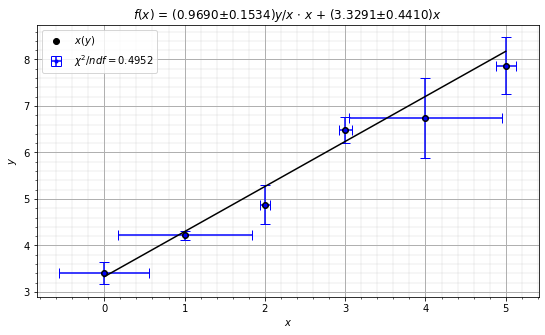

In [18]:
bsp()